In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import utils
# Optimization module in scipy
from scipy import optimize
from sklearn import metrics
# tells matplotlib to embed plots within the notebook
%matplotlib inline

# Clasification of adults that have an income larger than 50K

# Using a Neural Network
------------------------------------------
*******************************************

# Preprocesing

### Loading Processed Data

In [2]:
data_x = pd.read_csv('adult_processed_x.csv')

In [3]:
data_y= pd.read_csv('adult_processed_y.csv')

In [4]:
X= data_x.to_numpy()
print(X.shape)
print(X.dtype)

(32561, 88)
float64


In [5]:
y = data_y.to_numpy()
print(y.shape)
print(y.dtype)

(32561, 1)
int64


### Splitting Data

In [6]:
N = len(X)
N_train = int(0.5*N)      # The model  parameters for the network are adjusted using this set
N_val = int(0.25*N) # Use to tune parameters in the model. And avoid overfitting to the trainning set.  
N_test = N-N_train-N_val

# set random seed:
np.random.seed(0) 

# create a random permutation for splitting into training, validation and test
randperm = np.random.permutation(N)

# split into training and test
train_idx = randperm[:N_train]
val_idx = randperm[N_train:(N_train+N_val)]
test_idx = randperm[(N_train+N_val):]

Xtrain,Xval, Xtest = X[train_idx, :],X[val_idx, :], X[test_idx, :]
ytrain,yval, ytest = y[train_idx], y[val_idx] , y[test_idx]

print('Total number of samples:\t%d' % N)
print('Number of training samples:\t%d' % N_train)
print('Number of validation samples:\t%d' % N_val)
print('Number of test samples:\t%d' % N_test)
print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)

Total number of samples:	32561
Number of training samples:	16280
Number of validation samples:	8140
Number of test samples:	8141
(16280, 88)
(8140, 88)
(8141, 88)


# Model Evaluation

In [7]:
def model_evaluation(actual, pred):
    
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    
    
    TP = confusion.loc[1,1]
    TN = confusion.loc[0,0]
    FP = confusion.loc[0,1]
    FN = confusion.loc[1,0]
    
    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['sensitivity'] = sensitivity
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out

# Confusion Matrix Plotter

In [8]:
def confusion_matrix_plotter(val, pred):
    from sklearn.metrics import confusion_matrix
    from matplotlib.colors import LinearSegmentedColormap
    labels = list(range(2))
    #print(labels)
    
    cm = confusion_matrix(val, pred, labels=labels )
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    colors = [(1, 0, 0), (0, 1, 0)]
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=2)
    cax = ax.matshow(cm,cmap="coolwarm")
    
    fig.colorbar(cax)
    ax.set_xticks(labels)
    ax.set_yticks(labels)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # add numbers to squares
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center',color='white')

    
    plt.tight_layout()
    plt.ylabel("Predicted Class")
    plt.xlabel("Actual Class")
    plt.show()

# Utility functions

In [9]:
# ====================== MY CODE HERE ASSIG.4 ======================

def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    # Assignment 4
    W = np.zeros((L_out, 1 + L_in))
    # ====================== MY CODE HERE ======================
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    # ============================================================
    return W

In [10]:
# ====================== MY CODE HERE ASSIG.4 ======================
def matrix_of_y(y,num_labels):
    n = y.shape[0]
    y_v = np.zeros([n,num_labels])
    if(y_v.shape[1]==1):
        return y
    else:
        for r in range (n):
            y_v[r,y[r]] = 1
        return  y_v  

In [11]:
# ====================== MY CODE HERE ASSIG.3 ======================
def sigmoid(z):
    z = np.array(z)
    g = np.reciprocal((np.exp(z*-1))+1)
    
    return g

In [12]:
# ====================== MY CODE HERE ASSIG.4 ======================
def sigmoidGradient(z):
    
    g = np.zeros(z.shape)
    g_t = sigmoid(z)
    g= g_t*(1-g_t)
    
    return g

In [13]:
# ====================== MY CODE HERE ASSIG.4 ADAPTED======================
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    m = y.size
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    
    # ====================== MY CODE HERE ASSIG.4======================
    #Calculate hypothesis 
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1) # add x0 = 1
    z2 = np.matmul(Theta1,a1.T)
    a2 = sigmoid(z2)
    a2 = np.concatenate([np.ones((1, a2.shape[1])), a2], axis=0)
    z3 = np.matmul(Theta2,(a2))
    a3 = sigmoid(z3)
    almost_zero=1e-10
    hyp = a3.T
    y_v = matrix_of_y(y,num_labels)

    #Calculate cost function. 
    J = (-1 / m) * np.sum((np.log(hyp+almost_zero) * y_v) + np.log(1 - hyp+almost_zero) * (1 - y_v)) 

    #Calculate regularized cost function.
    temp_theta1 = Theta1[:,1:]
    temp_theta2 = Theta2[:,1:]

    J_reg_factor = (lambda_/(2*m))*(np.sum(np.square(temp_theta1))+np.sum(np.square(temp_theta2)))
    J_reg = J+J_reg_factor
    
    delta_3 = hyp - y_v+almost_zero
    delta_2 = delta_3.dot(Theta2)[:, 1:] * sigmoidGradient(a1.dot(Theta1.T))

    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2.T)
    # Add regularization to gradient
    Theta1_grad = (1 / m) * Delta1
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_ / m) * Theta1[:, 1:]
    
    Theta2_grad = (1 / m) * Delta2
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_ / m) * Theta2[:, 1:]
      
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    return J_reg, grad

In [14]:
# ====================== MY CODE HERE ASSIG.4 ======================
def randomInititalWeights(input_layer_size, hidden_layer_size,num_labels):
    initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
    # Unroll parameters
    initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)
    return initial_nn_params

In [15]:
def fowardPropagation(inputSet, theta1_input,theta2_input ):
    m= inputSet[:,0].size
    a1 = np.concatenate([np.ones((m, 1)), inputSet], axis=1) # add x0 = 1
    z2 = np.matmul(theta1_input,a1.T)
    a2 = sigmoid(z2)
    a2 = np.concatenate([np.ones((1, a2.shape[1])), a2], axis=0)
    z3 = np.matmul(theta2_input,(a2))
    a3 = sigmoid(z3)
    hyp = a3.T
    return hyp

In [16]:
def dispayPerformance(inputSetX, inputSetY,theta1_input,theta2_input,thresh):
    hyp_out = fowardPropagation(inputSetX,theta1_input,theta2_input)
    
    hyp_= [0 if value < thresh else 1 for value in hyp_out]
    accuracy_score= metrics.accuracy_score (inputSetY, hyp_)
    p_score = metrics.precision_score(inputSetY, hyp_)
    r_score = metrics.recall_score(inputSetY, hyp_) 
    f_score = metrics.f1_score(inputSetY, hyp_) 
    return accuracy_score,p_score, r_score,f_score
    

In [17]:
def plotData(trainError, valError,x,label_y,label_x):

    fig = plt.figure()  # open a new figure
    
    # ====================== YOUR CODE HERE ======================= 

    plt.plot(x, trainError, lw=2, label= 'Train Set')
    plt.plot(x, valError, lw=2,label= "Validation Set")
    plt.ylabel(label_y)
    plt.xlabel(label_x)
    plt.legend()

# Pre-Analysis

### Checking if data is biased 

The data is biased 
Only 25% of the data erans more than 50K 

In [18]:
large_income=y[y==1].size
print('Total number of samples with income above 50K:\t%d' % large_income)
print('Total number of samples :\t\t\t%d' % y.size)

Total number of samples with income above 50K:	7841
Total number of samples :			32561


### Model representation

Our neural network is shown in the following figure.

It has 3 layers - an input layer, a hidden layer and an output layer.
- Input layer has 88 layer units.
- Hidden layer 100 layer units.
- Output layer has 2 layer units. 


In [19]:
input_layer_size  = Xtrain.shape[1]    
num_labels = 1          # where 1 means (income => 50k)

# Neural Network

 ### Calculate optimal weights for neural network

In [20]:
def neuralNetwork(training_steps,lambda_in,hidden_layer_size):
    options= {'maxiter': training_steps}
    lambda_ = lambda_in
    
    
    costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, Xtrain, ytrain, lambda_)
    
    initial_rand_params= randomInititalWeights(input_layer_size,hidden_layer_size,num_labels)
    
    res = optimize.minimize(costFunction,
                            initial_rand_params,
                            jac=True,
                            method='TNC',
                            options=options)
    # get the solution of the optimization
    nn_params = res.x
    # Obtain Theta1 and Theta2 back from nn_params
    Theta1_train = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2_train= np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    return Theta1_train,Theta2_train,nn_params
    

# Tuning parameters

### Calculating optimal units in hidden layer

Conclusion: Most optimal number units in hidden layer-> 100 

In [21]:
hiden_units_values=np.array([10,20,40,75,78, 80,82,85,90,100,120,200])
train_error1 = np.zeros(hiden_units_values.size)
val_error1 =np.zeros(hiden_units_values.size)
step_units_input = 50
lambda_in = 1
for i in range(hiden_units_values.size):
    
    theta1,theta2,initial_nn_params = neuralNetwork(step_units_input,lambda_in,hiden_units_values[i])
    train_error1[i],_=nnCostFunction(initial_nn_params,input_layer_size,hiden_units_values[i],num_labels,Xtrain,ytrain)
    val_error1[i],_=nnCostFunction(initial_nn_params,input_layer_size,hiden_units_values[i],num_labels,Xval,yval)




In [22]:
print("Number of hidden layers with the least cost for Xval",hiden_units_values[np.argmin(val_error1)])

Number of hidden layers with the least cost for Xval 78


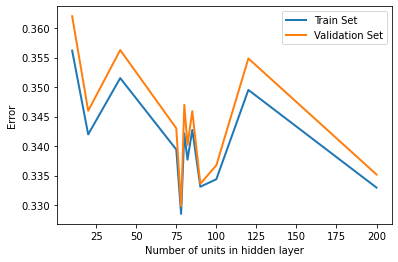

In [23]:
# def plotData(trainError, valError,x,label_y,label_x):
plotData(train_error1,val_error1,hiden_units_values,"Error","Number of units in hidden layer")


### Calculating optimal lambda 

Conclusion: Most optimal lambda -> 0.2 

In [24]:
lambda_values=np.array([0.1,0.2,0.4,0.8,1.6, 4,8,16,30])
train_error2 = np.zeros(lambda_values.size)
val_error2 =np.zeros(lambda_values.size)
step_units_input = 50
hiden_units_values_in = 82
for i in range(lambda_values.size):
    
    theta1,theta2,initial_nn_params = neuralNetwork(step_units_input,lambda_values[i],hiden_units_values_in)
    train_error2[i],_=nnCostFunction(initial_nn_params,input_layer_size,hiden_units_values_in,num_labels,Xtrain,ytrain)
    val_error2[i],_=nnCostFunction(initial_nn_params,input_layer_size,hiden_units_values_in,num_labels,Xval,yval)

print("Lambda value with the least error: ",lambda_values[np.argmin(val_error2)])

Lambda value with the least error:  0.1


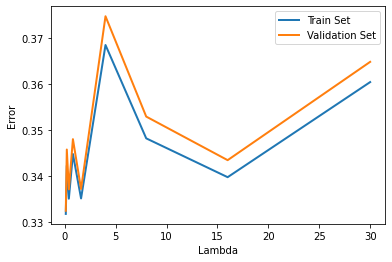

In [25]:
plotData(train_error2,val_error2,lambda_values,"Error","Lambda")


### Calculating optimal number of training steps 

Conclusion: The most optimal number of training steps -> 200. 

In [26]:
number_of_trainning_steps=np.array([50,100,200,250,300,400])
train_error3 = np.zeros(number_of_trainning_steps.size)
val_error3 =np.zeros(number_of_trainning_steps.size)
hiden_units_values_in = 100
lambda_in = 1
for i in range(number_of_trainning_steps.size):
    
    theta1,theta2,initial_nn_params = neuralNetwork(number_of_trainning_steps[i],lambda_in,hiden_units_values_in)
    train_error3[i],_=nnCostFunction(initial_nn_params,input_layer_size,hiden_units_values_in,num_labels,Xtrain,ytrain)
    val_error3[i],_=nnCostFunction(initial_nn_params,input_layer_size,hiden_units_values_in,num_labels,Xval,yval)




In [27]:
print("Number of trainning steps with the least error: ",number_of_trainning_steps[np.argmin(val_error3)])

Number of trainning steps with the least error:  300


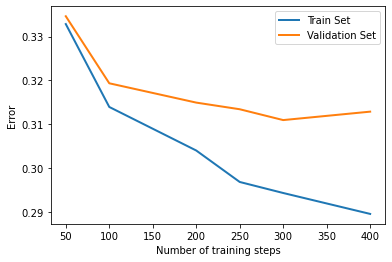

In [28]:
plotData(train_error3,val_error3,number_of_trainning_steps,"Error","Number of training steps")


### Calculating optimal threshold to classify people that earn above 50K dls

Conclusion: The most optimal threshold -> people earn more than 50kdl if hypothesis>0.3. 

In [29]:
thresholds = np.array([0.1,0.2,0.3,0.33,0.36,0.4,0.5,0.8])
train_f_score = np.zeros(thresholds.size)
train_presicion = np.zeros(thresholds.size)
train_recall = np.zeros(thresholds.size)
val_f_score =np.zeros(thresholds.size)
val_presicion =np.zeros(thresholds.size)
val_recall = np.zeros(thresholds.size)
hiden_units_values_in = 100
lambda_in = 0.2
number_of_trainning_steps=100

for i in range(thresholds.size):
    theta1,theta2,initial_nn_params = neuralNetwork(number_of_trainning_steps,lambda_in,hiden_units_values_in)
    _,train_presicion[i],train_recall[i],train_f_score[i]=dispayPerformance(Xtrain,ytrain,theta1,theta2,thresholds[i])
    _,val_presicion[i],val_recall[i],val_f_score[i],=dispayPerformance(Xval,yval,theta1,theta2,thresholds[i])


In [30]:
print("Threshold with the higher f-score for the validation set: ",thresholds[np.argmax(val_f_score)])



Threshold with the higher f-score for the validation set:  0.3


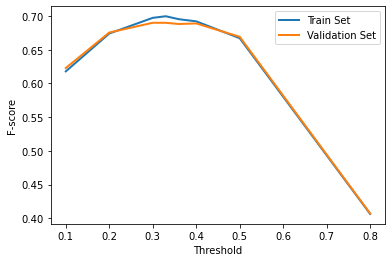

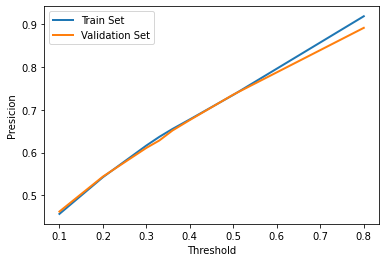

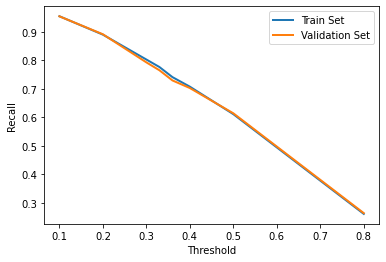

In [31]:
plotData(train_f_score,val_f_score,thresholds,"F-score","Threshold")

plotData(train_presicion,val_presicion,thresholds,"Presicion","Threshold")

plotData(train_recall,val_recall,thresholds,"Recall","Threshold")


# Testing model 
#### Parameters
- lambda = 1
- threshold = 0.3 
- number of units in hidden layer = 100
- number of trainning steps = 300

In [32]:
hiden_units_values_in = 100
lambda_in = 1
number_of_trainning_steps=300
threshold =0.3
theta1,theta2,initial_nn_params = neuralNetwork(number_of_trainning_steps,lambda_in,hiden_units_values_in)
   

In [33]:
accuracy,presicion,recall,f_score=dispayPerformance(Xtest,ytest,theta1,theta2,0.3)
print("TEST SET")
print("Accuracy:",accuracy)
print("Presicion:",presicion)
print("Recall:",recall)
print("F-Score:",f_score)

TEST SET
Accuracy: 0.8272939442328953
Presicion: 0.6023910528345545
Recall: 0.806401652039236
F-Score: 0.6896247240618102


In [34]:
accuracy,presicion,recall,f_score=dispayPerformance(Xtrain,ytrain,theta1,theta2,0.3)
print("TRAINING SET")
print("Accuracy:",accuracy)
print("Presicion:",presicion)
print("Recall:",recall)
print("F-Score:",f_score)

TRAINING SET
Accuracy: 0.838022113022113
Presicion: 0.6240791004265219
Recall: 0.8218023997957621
F-Score: 0.7094214876033057


# Analysis 

### Learning Curve

In [35]:

number_of_samples=np.array([16000,12000,8000,6000,4000,2000,1200,400,200,50,])
train_error4 = np.zeros(number_of_samples.size)
val_error4 =np.zeros(number_of_samples.size)
hiden_units_values_in = 100
lambda_in = 1
number_of_trainning_steps=100
for i in range(number_of_samples.size):
    Xtrain=Xtrain[:number_of_samples[i],:]
    ytrain=ytrain[:number_of_samples[i],:]
    theta1,theta2,initial_nn_params = neuralNetwork(number_of_trainning_steps,lambda_in,hiden_units_values_in)
    train_error4[i],_=nnCostFunction(initial_nn_params,input_layer_size,hiden_units_values_in,num_labels,Xtrain,ytrain)
    val_error4[i],_=nnCostFunction(initial_nn_params,input_layer_size,hiden_units_values_in,num_labels,Xval,yval)




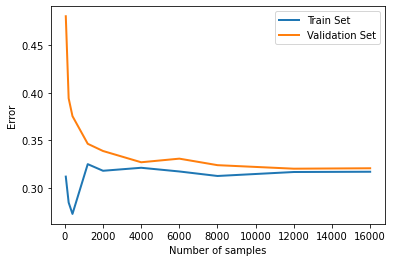

In [36]:
plotData(train_error4,val_error4,number_of_samples,"Error","Number of samples")


### Confusion Matrix

In [37]:

theta1,theta2,initial_nn_params = neuralNetwork(number_of_trainning_steps,lambda_in,hiden_units_values_in)
hyp_test = fowardPropagation(Xtest,theta1,theta2)

In [38]:
hyp_= [0 if value < 0.3 else 1 for value in hyp_test]

[0, 1]


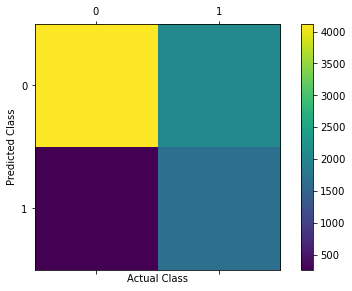

In [39]:
from sklearn.metrics import confusion_matrix
labels = list(range(2))
print(labels)
cm = confusion_matrix(y_true=ytest, y_pred=hyp_, labels=labels )
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticks(labels)
ax.set_yticks(labels)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.tight_layout()
plt.ylabel("Predicted Class")
plt.xlabel("Actual Class")
plt.show()

,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
logistic_reg,0.712075,0.445892,0.865772,0.588628,0.865772,0.664088,0.287925


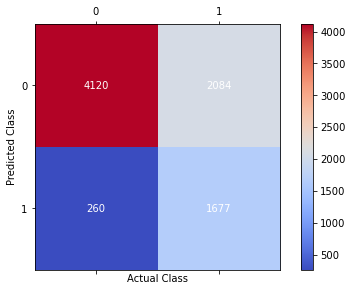

In [49]:
#print(ytest)
#print(hyp_)
#print(len(ytest))
#print(len(hyp_))
ANN=model_evaluation(ytest.flatten(),hyp_)
ovl_ANN = round(pd.DataFrame([ANN], index = ['logistic_reg']),6)
display(ovl_ANN)
print('\n')
confusion_matrix_plotter(ytest,hyp_)